In [1]:
from Pinns_Class import *
import matplotlib.pyplot as plt

Running on  cpu


### Cos_1D

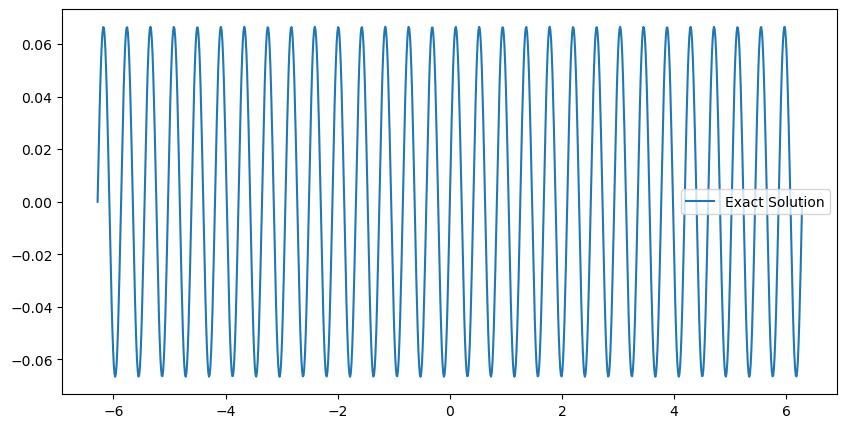

In [7]:
w = 15
n_hidden_layers = 2
neurons = 16
activation_function = nn.Tanh()

# Create the model
model = Cos_1D(w, n_hidden_layers, neurons, activation_function)

# Test the exact solution
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 1000, dtype=torch.float32, device=DEVICE, requires_grad=True).reshape(-1, 1)   # the input has to be of shape (n, 1)
u_exact = model.exact_solution(x_test)

fig = plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().detach().numpy(), u_exact.cpu().detach().numpy(), label='Exact Solution')
plt.legend()

In [8]:
num_points = 200*15
n_epochs = 6500
optimizer_ADAM = optim.Adam(model.parameters(),
                            lr=float(0.001))
history = model.fit(num_points, optimizer_ADAM, n_epochs, verbose=False)

Epoch :  0 	 Loss:  0.500927209854126 	 Epoch_time:  0  s
Epoch :  1 	 Loss:  0.5001277923583984 	 Epoch_time:  0  s
Epoch :  2 	 Loss:  0.4994570314884186 	 Epoch_time:  0  s
Epoch :  3 	 Loss:  0.4989137649536133 	 Epoch_time:  0  s
Epoch :  4 	 Loss:  0.4984913766384125 	 Epoch_time:  0  s
Epoch :  5 	 Loss:  0.49817603826522827 	 Epoch_time:  0  s
Epoch :  6 	 Loss:  0.4979458153247833 	 Epoch_time:  0  s
Epoch :  7 	 Loss:  0.4977738559246063 	 Epoch_time:  0  s
Epoch :  8 	 Loss:  0.49763545393943787 	 Epoch_time:  0  s
Epoch :  9 	 Loss:  0.4975135624408722 	 Epoch_time:  0  s
Epoch :  10 	 Loss:  0.49739986658096313 	 Epoch_time:  0  s
Epoch :  11 	 Loss:  0.49729225039482117 	 Epoch_time:  0  s
Epoch :  12 	 Loss:  0.4971919655799866 	 Epoch_time:  0  s
Epoch :  13 	 Loss:  0.49710068106651306 	 Epoch_time:  0  s
Epoch :  14 	 Loss:  0.49701955914497375 	 Epoch_time:  0  s
Epoch :  15 	 Loss:  0.49694833159446716 	 Epoch_time:  0  s
Epoch :  16 	 Loss:  0.4968852996826172 	 Ep

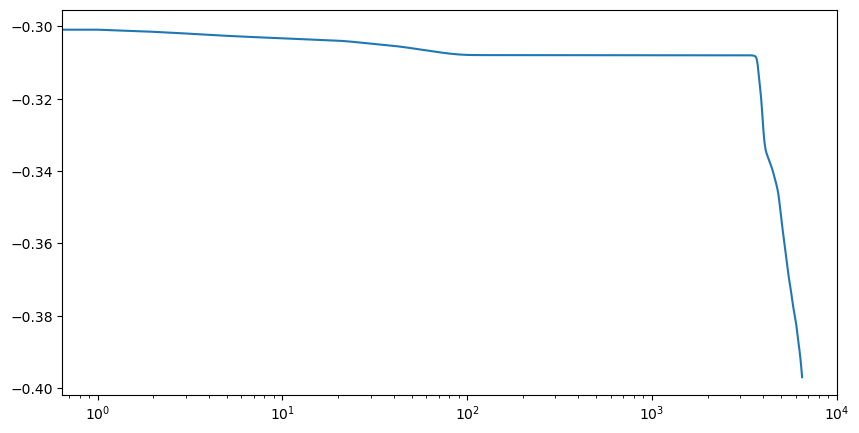

In [9]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs),np.log10(history), label='Loss')
# set log scale
plt.xscale('log')

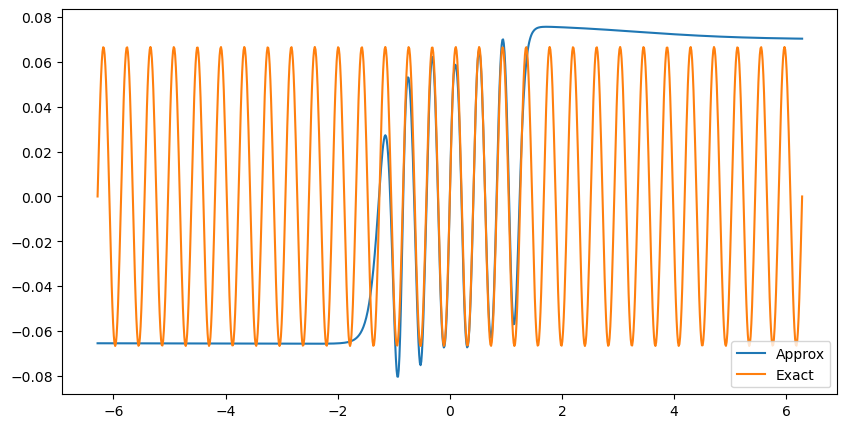

In [10]:
model.eval()
# u_approx = model(x_test)
u_exact = model.exact_solution(x_test)
# Approximate the solution with the NN building the ansatz
# u_approx = torch.tanh(model.w * model.normalize_input(x_test)) * model.unnormalize_output( model( model.normalize_input( x_test)) )
u_approx = torch.tanh(model.w * x_test) * model.unnormalize_output( model( model.normalize_input( x_test)) )


fig = plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().detach().numpy(), u_approx.cpu().detach().numpy(), label='Approx')
plt.plot(x_test.cpu().detach().numpy(), u_exact.cpu().detach().numpy(), label='Exact')
plt.legend()

### Cos_muldi1D

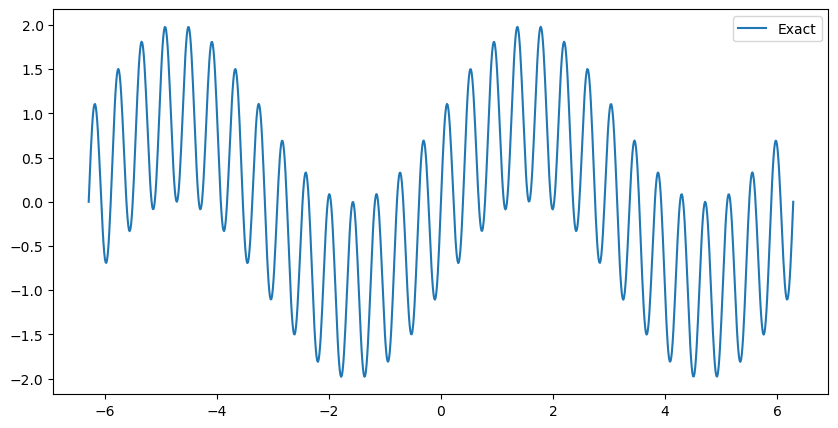

In [3]:
n_multi_scale = 2
w_list = [1, 15]
n_hidden_layers = 3
neurons = 20
activation_function = nn.Tanh()

# Create the model
model = PINN(n_multi_scale, w_list, n_hidden_layers, neurons, activation_function)

# Test the exact solution
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 1000, dtype=torch.float32, device=DEVICE)
u_exact = model.exact_solution(x_test)

fig = plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
plt.legend()

In [4]:
n_multi_scale = 1
w_list = [5]
n_hidden_layers = 3
neurons = 20
activation_function = nn.Tanh()

# Create the model
model = PINN(n_multi_scale, w_list, n_hidden_layers, neurons, activation_function)

# Test the exact solution
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 1000, dtype=torch.float32, device=DEVICE)
x_norm = model.normalize(x_test)
u_exact = model.exact_solution(x_test)
u_sol = torch.sin(x_test*w_list[0])

fig = plt.figure(figsize=(10, 5))
plt.plot(x_norm.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
plt.plot(x_norm.cpu().numpy(), u_sol.cpu().numpy(), label='Solution')
plt.legend()

AttributeError: 'PINN' object has no attribute 'normalize'

In [ ]:
torch.tanh(torch.tensor([1]))

tensor([0.7616])

In [ ]:
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 8, dtype=torch.float32, device=DEVICE)
print(x_test)

x_norm = model.normalize(x_test)
print(x_norm)

x_norm2 = model.normalize(x_norm)
print(x_norm2)

tensor([-6.2832, -4.4880, -2.6928, -0.8976,  0.8976,  2.6928,  4.4880,  6.2832])
tensor([-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000])
tensor([-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000])


### Test Domain Decomposition and Window fct

In [2]:
domain = [-2*torch.pi, 2*torch.pi]

fbpinn = FBPINN(domain_extrema=domain)
# make the subdomains
fbpinn.make_subdomains(n_subdomains=5, overlap=1.3)

subdomains = fbpinn.subdomains
midpoints = fbpinn.midpoints_overlap

In [3]:
subdomains

[[-6.283185307179586, -3.119911184307752],
 [-4.419911184307752, -0.6066370614359172],
 [-1.9066370614359172, 1.9066370614359172],
 [0.6066370614359172, 4.419911184307752],
 [3.119911184307752, 6.283185307179586]]

In [4]:
midpoints

[[-6.283185307179586, -3.7699111843077517],
 [-3.7699111843077517, -1.2566370614359172],
 [-1.2566370614359172, 1.2566370614359172],
 [1.2566370614359172, 3.7699111843077517],
 [3.7699111843077517, 6.283185307179586]]

(-0.1, 20.0)

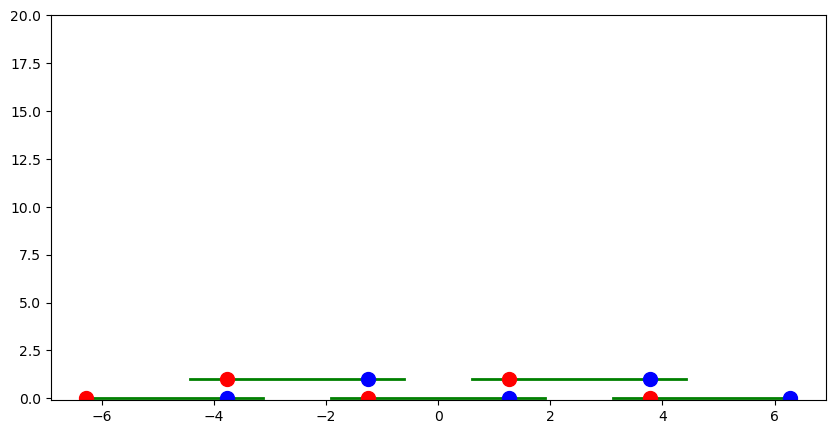

In [5]:
# plot the subdomains
fig = plt.figure(figsize=(10, 5))
for i in range(fbpinn.n_subdomains):
    x = np.linspace(subdomains[i][0], subdomains[i][1], 100)
    y = np.full(100, i%2)
    plt.plot(x, y, color='green', linewidth=2)
    plt.plot(midpoints[i][0], y[0], 'o', color='red', markersize=10)
    plt.plot(midpoints[i][1], y[0], 'o', color='blue', markersize=10)
plt.ylim(-0.1, 20)


In [6]:
window_fct = []
x = np.linspace(domain[0], domain[1], 1000)
for i in range(fbpinn.n_subdomains):
    window_fct.append(fbpinn.window_function(x, midpoints[i][0], midpoints[i][1], 0.1))

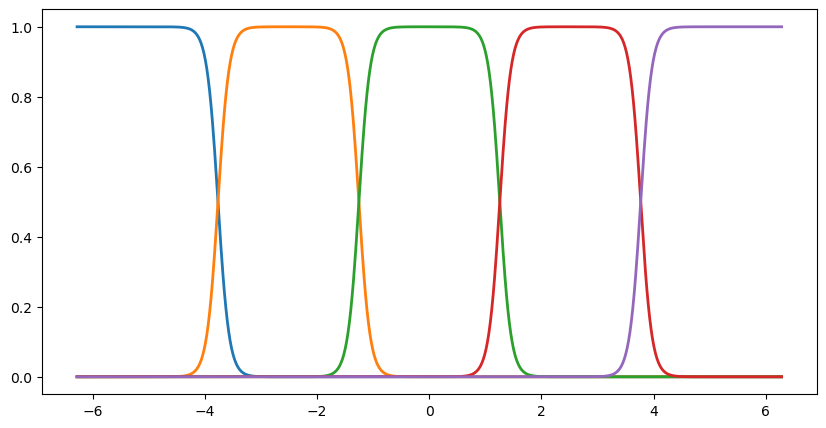

In [7]:
# plot the window functions
fig = plt.figure(figsize=(10, 5))
for i in range(fbpinn.n_subdomains):
    plt.plot(x, window_fct[i], linewidth=2)